# Importing the BONSAI database into brightway

BONSAI is a open database generated with [open code](https://gitlab.com/bonsamurais/bonsai). It is the outcome of the [GTDR](https://vbn.aau.dk/en/projects/getting-the-data-right) project, building on years of experience generating _hybrid_ input-output models.

In [36]:
from pathlib import Path
from collections import Counter
from IPython.display import Image

import bw2data as bd
import bw2io as bi
import bw2analyzer as bwa
import pandas as pd

from bw2io.importers.bonsai import BonsaiImporter,IOImporter

## basic setup

In [37]:
if 'bonsai_test' not in bd.projects:
    bi.remote.install_project('ecoinvent-3.10-biosphere','bonsai_test')

bd.projects.set_current('bonsai_test')

## importing BONSAI

For this presentation we've focused on the GHG, but BONSAI contains other elementary flows, like land, mineral, or fossil fuel use. 

the importer needs a mapping between the "emissions" in BONSAI and how they're called in the biosphere database.

In [38]:
biosphere_db = bd.Database(bd.config.biosphere)

# mapping between elements in the intervention matrix and the biosphere database
co_fossil = biosphere_db.get(name='Carbon monoxide, fossil',
                                     categories=('air',))
co2_non_fossil = biosphere_db.get(name='Carbon dioxide, non-fossil',
                                     categories=('air',))
co2_fossil = biosphere_db.get(name='Carbon dioxide, fossil',
                                     categories=('air',))
ch4_fossil = biosphere_db.get(name='Methane, fossil',
                                     categories=('air',))
ch4_non_fossil = biosphere_db.get(name='Methane, non-fossil',
                                     categories=('air',))
n2o = biosphere_db.get(name='Dinitrogen monoxide',categories=('air',))

# mapping between the name in the B matrix and the code in biosphere db
map_bonsai_b3 = {'Carbon_dioxide__fossil_Air': co2_fossil['code'],
 'Carbon_dioxide__biogenic_Air': co2_non_fossil['code'],
 'Methane__fossil_Air': ch4_fossil['code'],
 'Methane__biogenic_Air': ch4_non_fossil['code'],
 'Carbon_monoxide__fossil_Air':co2_non_fossil['code'],
 'Dinitrogen_monoxide_Air':n2o['code'],
 }

In [39]:
bonsai_data_path = Path("bonsai_files")

In [40]:
# build on a more generic IO importer that can be used for 
# importing other IO models.
issubclass(BonsaiImporter,IOImporter)

True

In [41]:
importer = BonsaiImporter(dirpath=bonsai_data_path,
                          db_name='bonsai', # whatever name you want to give it
                          b3mapping=map_bonsai_b3,
                          )

In [42]:
importer.write_database()

no extra biosphere flows added
10:30:01+0200 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 42088/42088 [00:02<00:00, 14319.64it/s]


10:30:07+0200 [info     ] Vacuuming database            
10:30:15+0200 [info     ] Starting IO table write       
10:30:17+0200 [info     ] Adding technosphere matrix    
10:30:20+0200 [info     ] Adding biosphere matrix       
10:30:21+0200 [info     ] Finalizing serialization      


In [43]:
bd.databases

Databases dictionary with 4 object(s):
	bonsai
	bonsai biosphere
	brightcon_dinner
	ecoinvent-3.10-biosphere

## general overview

In [44]:
bonsai_db = bd.Database('bonsai')

In [45]:
# this is a "lighter" backend since metadata on the exchanges was not needed
bonsai_db.backend

'iotable'

In [46]:
# number of activities
len(bonsai_db)

42088

In [47]:
n_locations = len({act['location'] for act in bonsai_db})

In [48]:
print(f"{n_locations} different locations")

50 different locations


In [ ]:
bonsai_db.graph_technosphere()

the database is relatively dense compared to a process-based LCA database

## calculating a carbon footprint

In [54]:
act = bonsai_db.random()
act

'production of apple juice, concentrated' (tonne, CH, None)

In [55]:
# some metadata available, to be improved
act.as_dict()

{'production volume': 14299.37002499968,
 'location': 'CH',
 'code': 'A_Juice_appl_con|CH',
 'unit': 'tonne',
 'reference product': 'apple juice, concentrated',
 'name': 'production of apple juice, concentrated',
 'database': 'bonsai',
 'type': 'processwithreferenceproduct',
 'id': 237130028785618974}

bear in mind units are often different from ecoinvent! the default unit of mass is tonne and of energy TJ !

In [56]:
gwp100 = ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')

In [57]:
lca = act.lca(gwp100)
print(f"{lca.score:.2f} {bd.Method(lca.method).metadata['unit']} per {act['unit']}")

1257.55 kg CO2-Eq per tonne


In [58]:
characterized_inventory = lca.to_dataframe(matrix_label='characterized_inventory')

<Axes: xlabel='kg CO2eq', ylabel='GHG'>

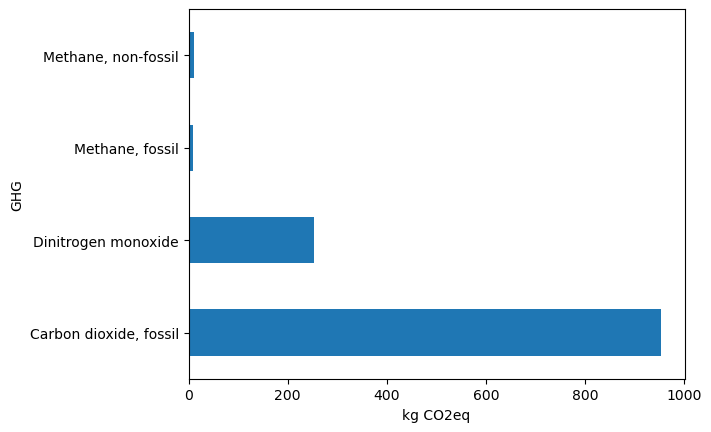

In [59]:
# e.g. contribution by elementary flow
characterized_inventory.pivot_table(index='row_name',
                                    values='amount',
                                    aggfunc='sum').amount.plot.barh(xlabel='kg CO2eq',
                                                                    ylabel='GHG',
                                                                    label='contribution by elementary flow')

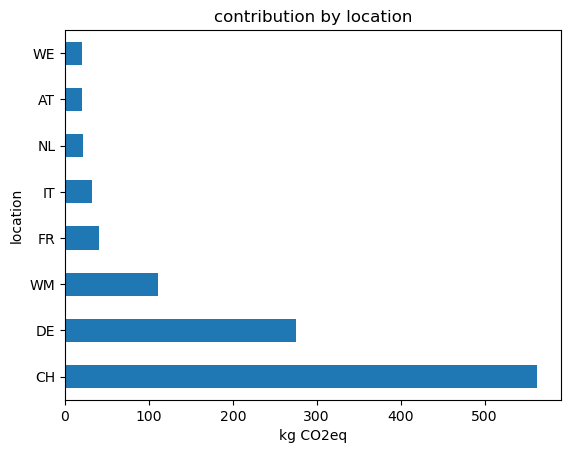

In [60]:
# contribution by location
characterized_inventory.pivot_table(index='col_location',
                                    values='amount',
                                    aggfunc='sum').sort_values(by='amount',
                                                               ascending=False).head(8).amount.plot.barh(
                                                               xlabel='kg CO2eq',ylabel='location',
                                                               title='contribution by location'
                                                               );

## io table backend

for those not familiar with this backend it is slightly different from the standard SQL backend

In [61]:
for e in act.edges():
    print(e)

Exchange: 14299.3701171875 tonne 'production of apple juice, concentrated' (tonne, CH, None) to 'production of apple juice, concentrated' (tonne, CH, None)>
Exchange: -0.11524484306573868 tonne 'aluminium and aluminium products - residual (market for)' (tonne, CH, None) to 'production of apple juice, concentrated' (tonne, CH, None)>
Exchange: -38129.04296875 tonne 'market product apples' (tonne, CH, None) to 'production of apple juice, concentrated' (tonne, CH, None)>
Exchange: -0.16856372356414795 tonne 'bkb/peat briquettes (market for)' (tonne, CH, None) to 'production of apple juice, concentrated' (tonne, CH, None)>
Exchange: -376.6480407714844 tonne 'plastic packaging, bottle, pet, (market for)' (tonne, CH, None) to 'production of apple juice, concentrated' (tonne, CH, None)>
Exchange: -0.0013221855042502284 tonne 'market product production of bricks, tiles and construction products, in baked clay' (tonne, CH, None) to 'production of apple juice, concentrated' (tonne, CH, None)>
Ex

## usage as a "LCA database"

In some sectors, like food, there is a tonne of open data from FAO.

### raclette 

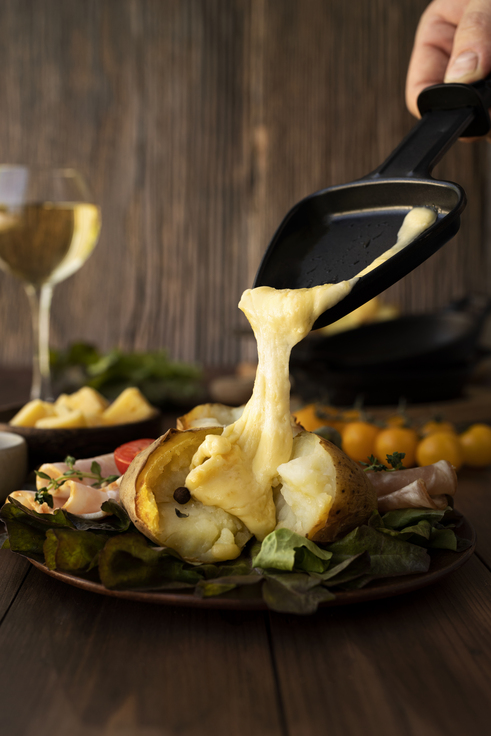

In [62]:
Image(filename='raclette_2.jpg') 

In [63]:
# some food products
cheese_goat = bonsai_db.get(name='market product cheese, goat milk',location='FR')
cheese_cow = bonsai_db.get(name='production of cheese, whole cow milk',location='FR')
cheese_sheep = bonsai_db.get(name='market product cheese, sheep milk',location='FR')
potatoes = bonsai_db.get(name='market product potatoes',location='FR') 
bread = bonsai_db.get(name='market product bread',location='FR')
bacon = bonsai_db.get(name = 'market product bacon and ham',location='FR')

In [65]:
brightcon_dinner = bd.Database('brightcon_dinner')
brightcon_dinner.register()

In [66]:
raclette = brightcon_dinner.new_node(code='raclette',
                                     name='raclette',
                                     location='FR',
                                     unit='item')
raclette.save()

In [67]:
raclette.new_edge(input=cheese_sheep,amount=0.2*1e-3,type="technosphere").save()
raclette.new_edge(input=cheese_cow,amount=0.2*1e-3,type="technosphere").save()
raclette.new_edge(input=cheese_goat,amount=0.25*1e-3,type="technosphere").save()

raclette.new_edge(input=bacon,amount=0.3*1e-3,type='technosphere').save()

raclette.new_edge(input=potatoes,amount=0.2*1e-3,type="technosphere").save()
raclette.new_edge(input=bread,amount=0.2*1e-3,type="technosphere").save()

In [68]:
raclette.new_edge(input=raclette,amount=1,type='production').save()

In [69]:
raclette = bd.Database('brightcon_dinner').get('raclette')

In [70]:
bwa.print_recursive_calculation(raclette,gwp100,max_level=2)

Fraction of score | Absolute score | Amount | Activity
0001 |  8.83 |     1 | 'raclette' (item, FR, None)
  0.177 | 1.561 | 0.0002 | 'market product cheese, sheep milk' (tonne, FR, None)
    -0.177 | -1.561 | -0.0001999 | 'production of cheese, sheep milk' (tonne, FR, None)
  0.344 | 3.038 | 0.0002 | 'production of cheese, whole cow milk' (tonne, FR, None)
    -0.335 | -2.96 | -0.001553 | 'market product cattle - milk' (tonne, FR, None)
  0.265 | 2.344 | 0.00025 | 'market product cheese, goat milk' (tonne, FR, None)
    -0.265 | -2.344 | -0.00025 | 'production of cheese, goat milk' (tonne, FR, None)
  0.201 | 1.774 | 0.0003 | 'market product bacon and ham' (tonne, FR, None)
    -0.0287 | -0.2536 | -3.331e-05 | 'production of pork meat' (tonne, BE, None)
    -0.0244 | -0.2155 | -3.66e-05 | 'production of pork meat' (tonne, DE, None)
    -0.0648 | -0.5724 | -8.81e-05 | 'production of pork meat' (tonne, ES, None)
    -0.0635 | -0.5607 | -0.0001189 | 'production of pork meat' (tonne, IT, N

In [71]:
df = bwa.utils.recursive_calculation_to_object(activity=raclette,
                                          lcia_method=gwp100,
                                          amount=1,
                                          as_dataframe=True,
                                          use_matrix_values=True,
                                          max_level=1)

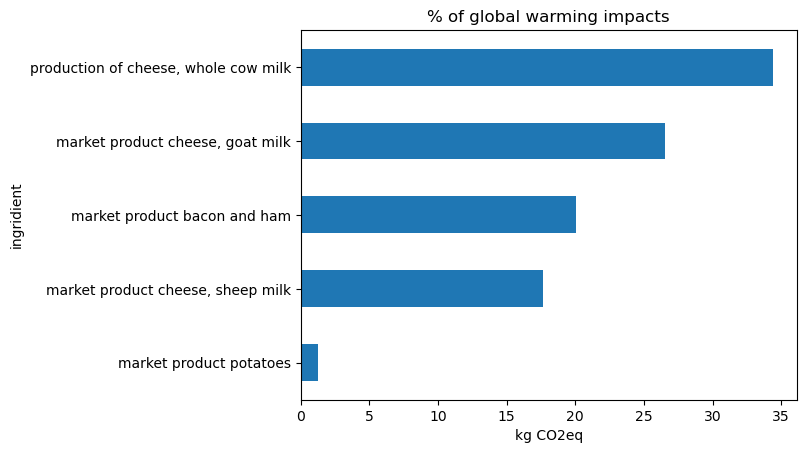

In [72]:
(df.dropna(subset='parent').set_index(
    'name').fraction.sort_values()*100).plot.barh(xlabel='kg CO2eq',
                                             ylabel='ingridient',
                                             title='% of global warming impacts');

### impact of household consumption 

In [73]:
household_cons = bonsai_db.get(name='final consumption expenditure by households',location='GB')

In [74]:
lca = household_cons.lca(gwp100)
lca.score

185681043788.5417

In [75]:
bwa.print_recursive_calculation(household_cons,gwp100,max_level=1,cutoff=0.06)

Fraction of score | Absolute score | Amount | Activity
0001 | 1.857e+11 |     1 | 'final consumption expenditure by households' (items, GB, None)
  -0.0661 | -1.228e+10 | -4.965e+05 | 'production of meat of cattle boneless, fresh, (market for)' (tonne, GB, None)
  -0.128 | -2.383e+10 | -1.822e+06 | 'cars(market for)' (items, GB, None)
  -0.561 | -1.041e+11 | -1.259e+06 | 'heat for households, (market for)' (TJ, GB, None)


### how is the database stored

In [76]:
pd.read_csv(bonsai_data_path/'extensions_value_table.gzip',compression='gzip').head()

,row,col,amount
0,2,0,4.748124e+05
1,2,1,2.091727e+06
2,2,2,8.927098e+04
3,2,3,8.139283e+05
4,2,4,4.454812e+06


In [77]:
pd.read_csv(bonsai_data_path/'index_table_hiot.gzip',compression='gzip').tail()

,col_region,col_code,row_region,row_code
42083,ID,F_NPSH,ID,F_NPSH
42084,SK,I_CHVA,SK,I_CHVA
42085,ZA,F_GOVE,ZA,F_GOVE
42086,KR,F_NPSH,KR,F_NPSH
42087,TR,F_NPSH,TR,F_NPSH
